# 2019 DATA SCIENCE BOWL

### Summary
In this challenge, you’ll use anonymous gameplay data, including knowledge of videos watched and games played, from the PBS KIDS Measure Up! app, a game-based learning tool. Competitors will be challenged to predict scores on in-game assessments and create an algorithm that will lead to better-designed games and improved learning outcomes. 
Your solutions will aid in discovering important relationships between engagement with high-quality educational media and learning processes.

### Get modules needed

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from IPython.display import HTML
import warnings
pd.set_option('max_columns', 100)
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
my_pal = sns.color_palette(n_colors=10)

# set_options set maximum columns to 100
# set stype and increased color palette for charting

### Load Dataset

First we will see what files we are given to work with. Note the train.csv file is quite large at 3.7G. From the data description we know:
- train.csv & test.csv : These are the main data files which contain the gameplay events.
- specs.csv : This file gives the specification of the various event types.
- train_labels.csv : This file demonstrates how to compute the ground truth for the assessments in the training set.
- sample_submission.csv : A sample submission in the correct format.

In [1]:
# List current directory
import os
os.getcwd()

'C:\\Users\\sandra\\Documents\\GitHub'

In [39]:
# Change working directory
os.chdir('c:/Users/sandra/Documents/DataScienceProjects/DataBowl')  
os.getcwd()

'c:\\Users\\sandra\\Documents\\DataScienceProjects\\DataBowl'

In [40]:
# os.listdir()
!ls

 Volume in drive C has no label.
 Volume Serial Number is A013-71D9

 Directory of c:\Users\sandra\Documents\DataScienceProjects\DataBowl

11/21/2019  10:08 AM    <DIR>          .
11/21/2019  10:08 AM    <DIR>          ..
11/21/2019  10:08 AM            11,031 sample_submission.csv
11/21/2019  10:08 AM           408,868 specs.csv
11/21/2019  10:08 AM       398,327,795 test.csv
11/21/2019  10:09 AM     3,878,373,417 train.csv
11/21/2019  10:08 AM         1,124,229 train_labels.csv
               5 File(s)  4,278,245,340 bytes
               2 Dir(s)  159,468,392,448 bytes free


In [18]:
# Read in the data CSV files
train = pd.read_csv ('c:\\Users\\sandra\\Documents\\DataScienceProjects\\DataBowl\\train.csv')
train_labels = pd.read_csv ('c:\\Users\\sandra\\Documents\\DataScienceProjects\\DataBowl\\train_labels.csv')
test = pd.read_csv ('c:\\Users\\sandra\\Documents\\DataScienceProjects\\DataBowl\\test.csv')
specs = pd.read_csv ('c:\\Users\\sandra\\Documents\\DataScienceProjects\\DataBowl\\specs.csv')
ss = pd.read_csv ('c:\\Users\\sandra\\Documents\\DataScienceProjects\\DataBowl\\sample_submission.csv')


The training data is so large, we will take a random sample of it for plotting. Since we are doing this at random it will speed up the time it takes to plot but still give us a a good view of the data's format. Later, can load the data in as manageable
bits and then do the same plotting procedure.

In [19]:
train_ = train.sample(1000000) #sample 1M observations

# What are we predicting?

First we will look at the target we intend to predict.

We are told: The intent of the competition is to use the gameplay data to forecast how many attempts a child will take to pass a given assessment (an incorrect answer is counted as an attempt). 

The outcomes in this competition are grouped into 4 groups (labeled accuracy_group in the data):
- 3: the assessment was solved on the first attempt
- 2: the assessment was solved on the second attempt
- 1: the assessment was solved after 3 or more attempts
- 0: the assessment was never solved

In [20]:
train_labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


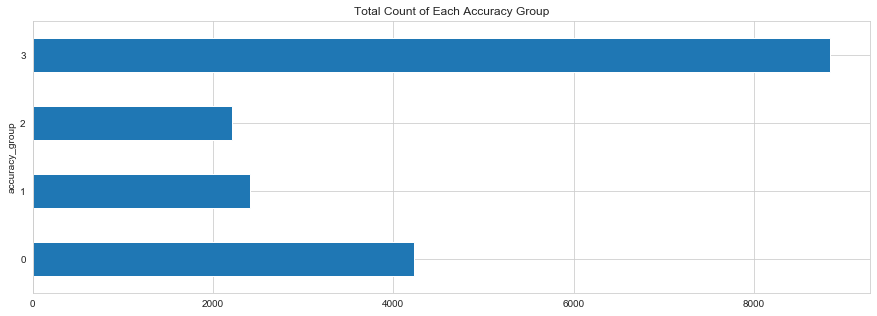

In [33]:
# Get a count of how many instances for 0,1,2,3 in accuracy_group
train_labels.groupby('accuracy_group')['game_session'].count() \
    .plot(kind='barh', figsize=(15, 5), title='Total Count of Each Accuracy Group')
plt.show()

# Notes about accuracy_group
- Accuracy_group 3 (which is right on the first attempt) accounts for approximately 50% of the total count.
- Accuracy_group 2 & 1 accounts for approximately 12.5% each.
- Accuracy_group 0 account for approximately 25%
- These percentage values can be used as a judge to determine if the difficulty of the questions should be harder so accuracy_group 3 makes up less than 50% or perhaps it is desired that the accuracy_group 3 makes up more than 50% then the questions should be easier.
- The percentage of each accuracy_group can be used as a rough guide to forecast the number of attempts. Since 50% of the time they will get it right on the first attempt, 12.5% of the time will be 1 attempt, 12.5% of the time will be 3 or more attempts and 25% of the time will not be solved.


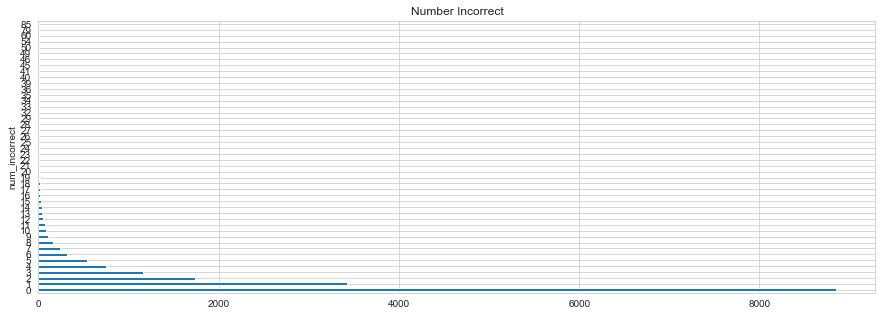

In [34]:
train_labels.groupby('num_incorrect')['game_session'].count() \
    .plot(kind='barh', figsize=(15, 5), title='Number Incorrect')
plt.show()


The chart has too many values on at the lower extremes to get a good idea of what the higher extremes are.

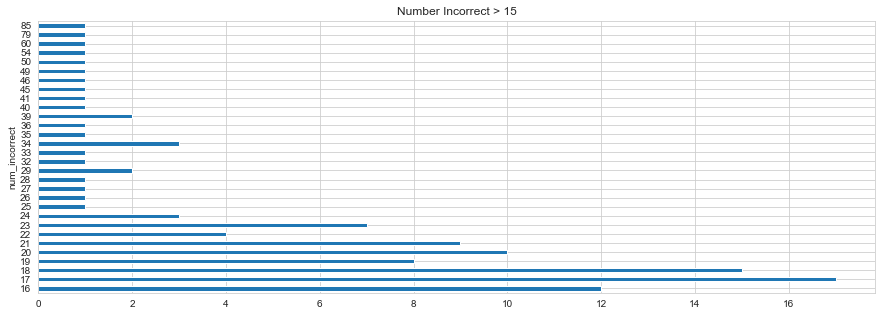

In [42]:
# Separate the number incorrect to only include those above 15
high_values = train_labels[(train_labels['num_incorrect'] > 15)]
high_values.groupby('num_incorrect')['game_session'].count() \
    .plot(kind='barh', figsize=(15, 5), title='Number Incorrect > 15')
plt.show()

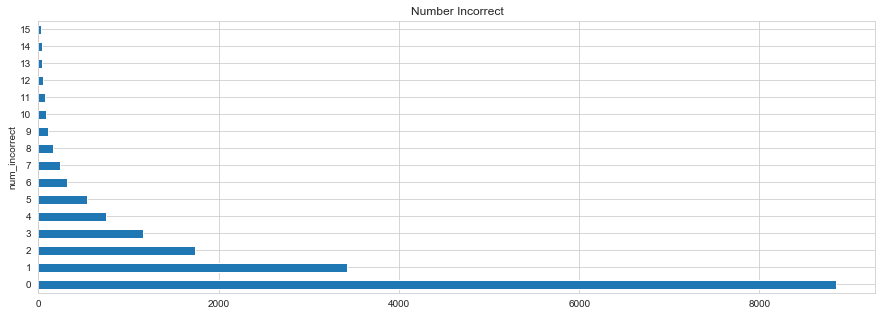

In [41]:
# Separate the number incorrect to only include those below & including 15
high_values = train_labels[(train_labels['num_incorrect'] <= 15)]
high_values.groupby('num_incorrect')['game_session'].count() \
    .plot(kind='barh', figsize=(15, 5), title='Number Incorrect 15 & Below')
plt.show()

- After breaking the chart up, it can be seen that the majority over 25 are just one instance so excluding them should be considered.
- Realistically speaking, a child is very unlikely to try 85 times to get a problem correct. But what would  